# Loads the processed h5 file and plots data

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [2]:
# input parameters
run_num = 110

# constants
detector_distance = 0.1249 # m
energy = 9.5 # keV

# hit finders parameters
iq_thr = 0.5 # photon/pix
r_min, r_max = 200,400 # bins

# ice finder parameters
filter_length = 1
ice_thr = 1. # delta photon/pix
q_min, q_max = 1.0,4.5 # A-1

### load and analyse data

In [3]:
# load data
run = discover_run_h5(run_num)[3:-3]
img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run)

# convert q_scale
q = q_scale(r,detector_distance=detector_distance,photon_energy=energy*1000)

# convert intensity to photon/pix
img_hits/=energy
Iq /=energy
i0 /=energy

# normalise to i0
Iq_norm = np.zeros(Iq.shape)
i0_avg = np.average(i0)
norm = i0/i0_avg
for i in range(int(nshots)):
    Iq_norm[i]=Iq[i]/norm[i]
    
# find hits
metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=r_min,r_max=r_max)
hit_rate =len(hits[hits>0])/nshots

# find ice
ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, filter_length=filter_length, q_min=q_min, q_max=q_max)
ice_avg = np.average(Iq[ice_hits],axis=0)

# exclude ice hits
hits *= np.logical_not(ice_hits)

# subtract background
Iq_corr = subtract_background(Iq,hits,i0,nshots)
hit_avg = np.average(Iq_corr,axis=0)
miss_avg = np.average(Iq[hits],axis=0) - np.average(Iq_corr,axis=0)

# pump probe (new method)
diff_signal_2 = pump_probe_signal_2(Iq_corr,hits,laser_on,r_min=r_min,r_max=r_max)

run0110_droplets_10um_28mm: 17998 shots
(239, 1000)


### plot

<IPython.core.display.Javascript object>


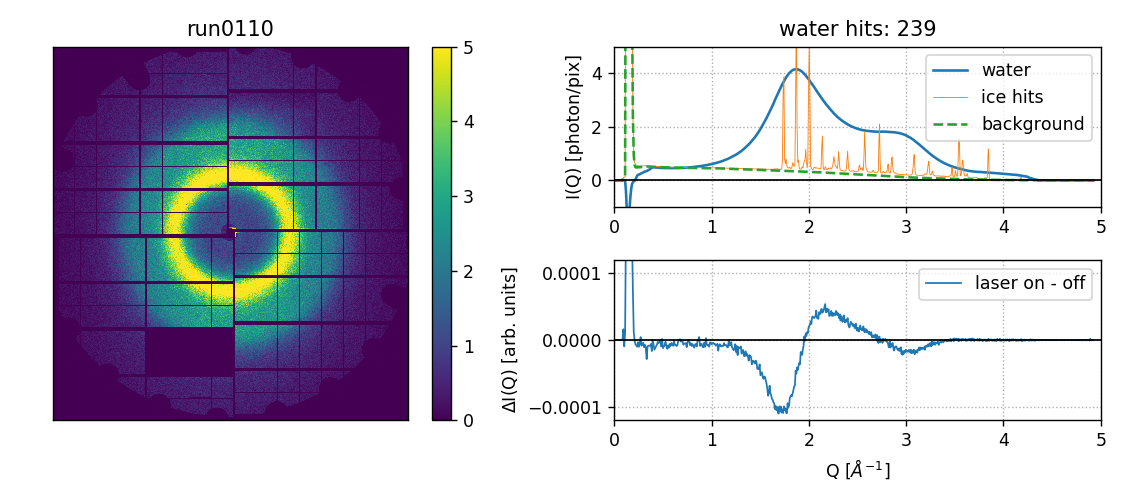

In [4]:
plt.figure(figsize=[9,4])
plt.subplot(1,2,1)
plt.title('run%s'%run[:4])
plt.imshow(img_hits/nhits,clim=[0,5],origin='lower')
plt.colorbar()
plt.xticks([],'')
plt.yticks([],'')
plt.tight_layout()

plt.subplot(2,2,2)
plt.title('water hits: %d'%(hits.sum()))
plt.plot(q,hit_avg , label='water')
plt.plot(q,ice_avg,label ='ice hits',lw=0.5)
plt.plot(q,miss_avg ,'--',label='background')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right')
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.ylim(-1,5)

ax = plt.subplot(2,2,4)
ax.plot(q, diff_signal_2, label='laser on - off',lw=1)
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.ylim([-1.2e-4,1.2e-4])
plt.xlabel('Q [$\AA^{-1}$]')
plt.legend()
plt.xlim(0,5)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=1)

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


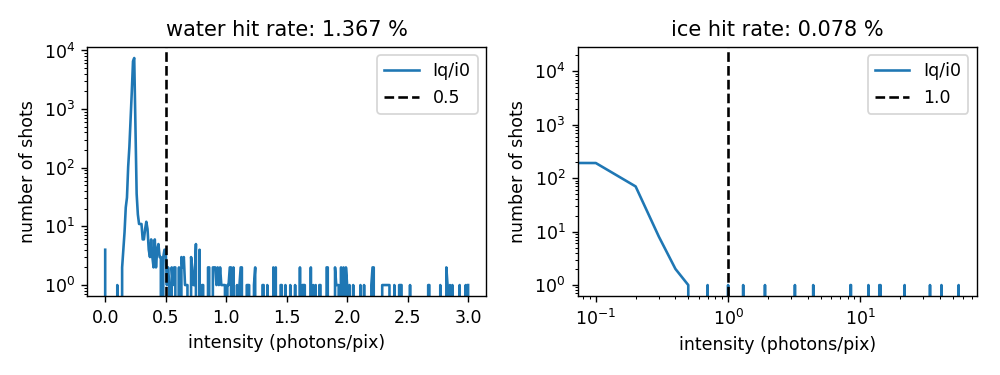

In [5]:
plt.figure(figsize=[8,3])

plt.subplot(1,2,1)
x,y = do_histogram(metric,0,3,.01)
plt.plot(x,y)
plt.axvline(x=iq_thr,c='black',ls='--')
plt.legend(['Iq/i0',iq_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
#plt.xscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.title('water hit rate: %.3f %%'%(hit_rate*100))
plt.tight_layout()

plt.subplot(1,2,2)
x,y = do_histogram(ice_metric,0,ice_metric.max(),.1)
plt.plot(x,y)
plt.axvline(x=ice_thr,c='black',ls='--')
plt.legend(['Iq/i0',ice_thr])
plt.ylabel('number of shots')
plt.yscale('log',nonposy='clip')
plt.xlabel('intensity (photons/pix)')
plt.xscale('log',nonposy='clip')
plt.title('ice hit rate: %.3f %%'%(ice_hits.sum()/nshots*100))
plt.tight_layout()

plt.show()